- 图从一组观测数据中估计出数据的概率分布，但 MLE 是“参数化”方法，而 KDE 是“非参数化”方法。
    - MLE 的核心思想是：模型已经确定，参数未知。我们要做的是找到一组参数，使得我们观测到的这组样本数据出现的概率（似然）最大。
        - $ L(\mu, \sigma | \mathbf{x}) = \prod_{i=1}^{N} \left[ \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right) \right] $
        - $ \ell = \log(L) = \log \left( \prod_{i=1}^{N} P(x_i | \mu, \sigma) \right) $
    - KDE 的核心思想是：我们对数据的真实分布一无所知。我们不预设任何模型，而是直接从数据本身出发，去拟合出一条平滑的密度曲线。
        - 密度是什么？就是一个区域内数据点的密集程度。KDE 认为，在数轴上的任何一个点 $x$ 的密度，都受到了其附近所有观测数据点 $x_i$ 的影响。一个观测点 $x_i$ 对其周围的密度有贡献，离 $x_i$ 越近，贡献越大。
        - $ \hat{f}_h(x) = \frac{1}{Nh} \sum_{i=1}^{N} K\left(\frac{x - x_i}{h}\right) $
            - $K(\cdot)$: 核函数 (kernel)。这是一个非负的、积分为1的对称函数。它定义了放置在每个数据点上的“波峰”的形状。
            - $K(u) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}u^2}$
            - $K(u) \propto e^{-\frac{1}{2}u^2} \quad \text{其中 } u = \frac{x - x_i}{h}$
                - 衰减得非常快，当一个数据点 $x_i$ 离目标点 $x$ 很远时，比如距离超过了带宽 $h$ 的3倍/4倍，$|x-x_i|\gt 4h$，$u$ 就会很大，$e^{-\frac{1}{2}u^2}$ 就会变得及其微小，$e^{-8} \approx 0.000335$
        - 不对数据分布做任何假设，无参数，在预测/评估阶段，必须使用全部原始数据。

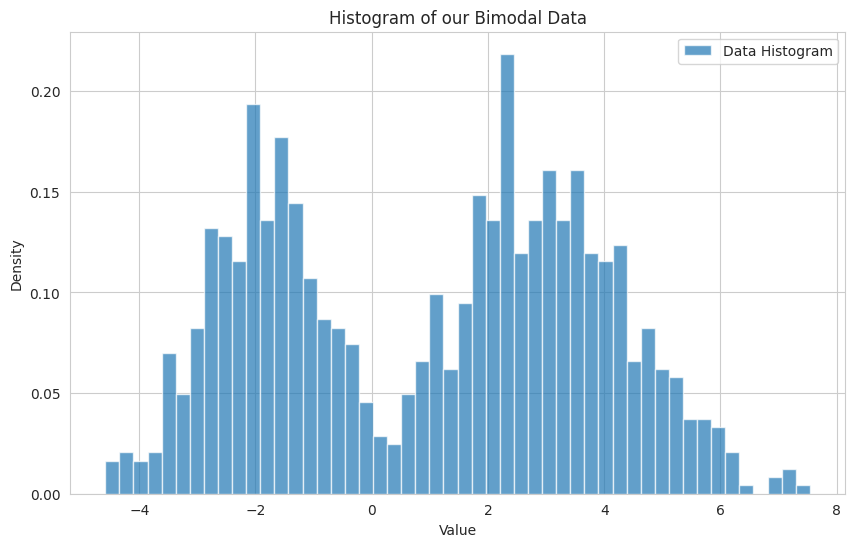

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set_style("whitegrid")

# --- 数据生成 ---
# 我们知道真实分布，但建模时假装不知道
torch.manual_seed(42)
n_samples = 1000

# 第一个分布
samples1 = torch.randn(int(n_samples * 0.4)) * 1.0 - 2.0

# 第二个分布
samples2 = torch.randn(int(n_samples * 0.6)) * 1.5 + 3.0

# 混合数据
data = torch.cat([samples1, samples2])

# 绘制数据的直方图，看看它长什么样
plt.figure(figsize=(10, 6))
plt.hist(data.numpy(), bins=50, density=True, alpha=0.7, label="Data Histogram")
plt.title("Histogram of our Bimodal Data")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

### MLE

$$ 
\log L(\mu, \sigma | \mathbf{x}) = -\frac{N}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{N}(x_i - \mu)^2 
$$

In [2]:
mu = torch.nn.Parameter(torch.tensor(0.0)) # 初始猜测 mu=0
log_sigma = torch.nn.Parameter(torch.tensor(0.0)) # 初始猜测 sigma=exp(0)=1

# 2. 设置优化器
optimizer = torch.optim.Adam([mu, log_sigma], lr=0.01)

# 3. 优化循环
print("Starting MLE Optimization...")
for step in range(2001):
    # 清零梯度
    optimizer.zero_grad()
    
    # 从 log_sigma 计算 sigma
    sigma = torch.exp(log_sigma)
    
    # 创建一个正态分布对象
    # 这是 PyTorch 中计算概率和似然的便捷方式
    dist = torch.distributions.Normal(mu, sigma)
    
    # 计算负对数似然 (NLL)
    # log_prob 是对数概率密度，我们要求和并取反
    nll = -dist.log_prob(data).sum()
    
    # 反向传播，计算梯度
    nll.backward()
    
    # 更新参数
    optimizer.step()
    
    if step % 200 == 0:
        print(f"Step {step}, NLL: {nll.item():.4f}, mu: {mu.item():.4f}, sigma: {sigma.item():.4f}")

# 最终估计出的参数
mle_mu = mu.item()
mle_sigma = torch.exp(log_sigma).item()
print(f"\nMLE Finished!")
print(f"Estimated mu: {mle_mu:.4f}")
print(f"Estimated sigma: {mle_sigma:.4f}")

Starting MLE Optimization...
Step 0, NLL: 5213.8901, mu: 0.0100, sigma: 1.0000
Step 200, NLL: 2452.5837, mu: 0.8036, sigma: 2.4348
Step 400, NLL: 2432.9480, mu: 0.9472, sigma: 2.7283
Step 600, NLL: 2432.6792, mu: 0.9883, sigma: 2.7550
Step 800, NLL: 2432.6736, mu: 0.9965, sigma: 2.7559
Step 1000, NLL: 2432.6736, mu: 0.9975, sigma: 2.7559
Step 1200, NLL: 2432.6733, mu: 0.9975, sigma: 2.7559
Step 1400, NLL: 2432.6733, mu: 0.9975, sigma: 2.7559
Step 1600, NLL: 2432.6733, mu: 0.9975, sigma: 2.7559
Step 1800, NLL: 2432.6733, mu: 0.9975, sigma: 2.7559
Step 2000, NLL: 2432.6733, mu: 0.9975, sigma: 2.7559

MLE Finished!
Estimated mu: 0.9975
Estimated sigma: 2.7559


### KDE

- `kde.fit(data.reshape(-1, 1))`

In [3]:
from sklearn.neighbors import KernelDensity

# 1. 创建 KDE 模型
# bandwidth 是最重要的超参数，这里我们凭经验选择 0.5
# 你可以尝试不同的值看看效果
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)

# 2. 拟合数据
# scikit-learn 需要 (n_samples, n_features) 格式的数据
kde.fit(data.reshape(-1, 1))

# 3. 生成用于绘图的密度曲线
# 创建一系列点来评估密度
x_plot = torch.linspace(-6, 8, 1000).reshape(-1, 1)

# 计算这些点上的对数密度 (score_samples 返回 log-density)
log_dens = kde.score_samples(x_plot)

# 将对数密度转换为实际密度
kde_pdf = np.exp(log_dens)

print("\nKDE Finished!")
print("KDE model has been fitted to the data.")


KDE Finished!
KDE model has been fitted to the data.


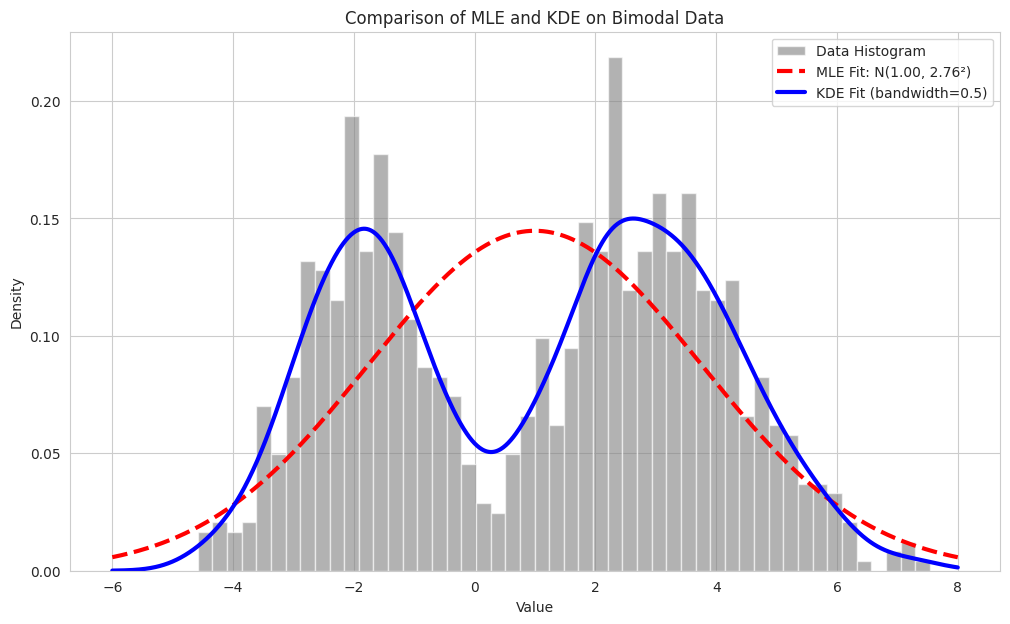

In [4]:
# --- 可视化对比 ---
plt.figure(figsize=(12, 7))

# 绘制原始数据直方图
plt.hist(data.numpy(), bins=50, density=True, alpha=0.6, label="Data Histogram", color='gray')

# 绘制 MLE 的结果 (单一正态分布)
mle_dist = torch.distributions.Normal(mle_mu, mle_sigma)
mle_pdf = torch.exp(mle_dist.log_prob(x_plot.squeeze()))
plt.plot(x_plot.numpy(), mle_pdf.numpy(), color='red', lw=3, linestyle='--', label=f"MLE Fit: N({mle_mu:.2f}, {mle_sigma:.2f}²)")

# 绘制 KDE 的结果
plt.plot(x_plot.numpy(), kde_pdf, color='blue', lw=3, label="KDE Fit (bandwidth=0.5)")

plt.title("Comparison of MLE and KDE on Bimodal Data")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()